In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [488]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [12]:
# Calculate the date 1 year ago from the last data point in the database

session.query(Measurement.date).order_by(Measurement.date.desc()).first() #2017-08-23

('2017-08-23')

In [13]:
year_ago = (dt.date(2017, 8 , 23) - dt.timedelta(days=365)).strftime("%Y, %m, %d")
year_ago

'2016, 08, 23'

In [14]:
# Perform a query to retrieve the data and precipitation scores
for_df = []

for row in session.query(Measurement).\
    filter(Measurement.date > '2016-08-23'):
    for_df.append({
        "id": row.id,
        "station": row.station, 
        "date": row.date, 
        "prcp": row.prcp,
        "tobs": row.tobs
    })

len(for_df)

2223

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame.from_records(for_df)
df.head()

,date,id,prcp,station,tobs
0,2016-08-24,2365,0.08,USC00519397,79.0
1,2016-08-25,2366,0.08,USC00519397,80.0
2,2016-08-26,2367,0.00,USC00519397,79.0
3,2016-08-27,2368,0.00,USC00519397,77.0
4,2016-08-28,2369,0.01,USC00519397,78.0


In [16]:
# Sort the dataframe by date
df.set_index(['date'], inplace=True)
df.head()

,id,prcp,station,tobs
date,,,,
2016-08-24,2365,0.08,USC00519397,79.0
2016-08-25,2366,0.08,USC00519397,80.0
2016-08-26,2367,0.00,USC00519397,79.0
2016-08-27,2368,0.00,USC00519397,77.0
2016-08-28,2369,0.01,USC00519397,78.0


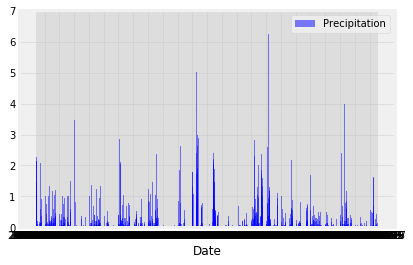

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(df.index, df.prcp, label = 'Precipitation', color='blue', alpha = .5, align='edge')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=.5)
# plt.figure(figsize=(20,10))

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,id,prcp,tobs
count,2223.000000,2015.000000,2223.000000
mean,10159.397211,0.176462,74.578947
std,5604.268703,0.460288,4.612232
min,2365.000000,0.000000,58.000000
25%,5287.500000,0.000000,71.000000
50%,8931.000000,0.020000,75.000000
75%,14751.500000,0.130000,78.000000
max,19550.000000,6.700000,87.000000


In [19]:
# Design a query to show how many stations are available in this dataset? #9
session.query(Measurement.station).distinct().count()

9

In [42]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

    # engine.execute('''SELECT m.station, count(m.station)\
    #     FROM measurement m\
    #     GROUP BY 1\
    #     ORDER BY 2 DESC''').fetchall()

    # pd.read_sql('''SELECT m.station, count(m.station)\
    #         FROM measurement m\
    #         GROUP BY 1\
    #         ORDER BY 2 DESC''',\
    #         engine)

for row in session.query(Measurement.station.distinct(), func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()):
    print(row)
    

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [43]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station? #USC00519281


    # engine.execute('''
    #     SELECT m.station, max(m.tobs), min(m.tobs), avg(m.tobs)
    #     FROM measurement m
    #     WHERE m.station = "USC00519281"
    #     GROUP BY 1
    #     ''').fetchall()

for row in session.query(Measurement.station, \
    func.max(Measurement.tobs), \
    func.min(Measurement.tobs), \
    func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.station):
    print(row)

('USC00519281', 85.0, 54.0, 71.66378066378067)


In [44]:
for_df2 = []

for row in session.query(Measurement).\
    filter(Measurement.date > '2016-08-23').\
    filter(Measurement.station == "USC00519281"):
    for_df2.append({
        "id": row.id,
        "station": row.station, 
        "date": row.date, 
        "prcp": row.prcp,
        "tobs": row.tobs
    })

df2 = pd.DataFrame.from_records(for_df2)
len(df2)

351

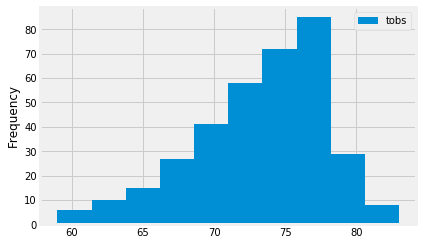

In [45]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.hist(df2.tobs, label='tobs')
plt.ylabel('Frequency')
plt.legend()

In [46]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [47]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
miami_trip = calc_temps('2017-02-22', '2017-02-26') #MIAMI TRIP
p2p = miami_trip[0][2] - miami_trip[0][0]

In [48]:
x=1
miami_avg = miami_trip[0][1]

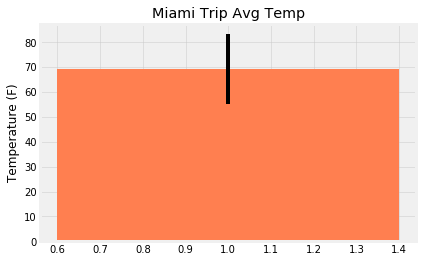

In [49]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(x, miami_avg,yerr=p2p, color='coral')
plt.title('Miami Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.grid(alpha=.5)

In [50]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


# engine.execute('''
#     SELECT m.station, sum(prcp)
#     FROM measurement m
#     WHERE m.date >= '2017-02-22' and m.date <= '2017-02-26'
#     GROUP BY 1
#     ORDER BY 2 DESC
#     ''').fetchall()

for row in session.query(Measurement.station,\
    func.sum(Measurement.prcp)).\
    filter(Measurement.date >= '2017-02-22').\
    filter(Measurement.date <= '2017-02-26').\
    group_by(Measurement.station):
    print(row)


('USC00513117', 0.06)
('USC00514830', 0.11)
('USC00516128', 0.44)
('USC00517948', 0.17)
('USC00519281', 0.06)
('USC00519397', 0.09999999999999999)
('USC00519523', 0.13)


## Optional Challenge Assignment

In [51]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [65]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
miami_dates = ('02-22', '02-23', '02-24', '02-25', '02-26')
# Loop through the list of %m-%d strings and calculate the normals for each date

for_df3 = []
for x in miami_dates:
    info = daily_normals(x)
    date = x
    tmin = info[0][0]
    tavg = info[0][1]
    tmax = info[0][2]
    for_df3.append({
        'date' : date,
        'tmin' : tmin,
        'tavg' : tavg,
        'tmax' : tmax,
    })

In [66]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df3 = pd.DataFrame.from_records(for_df3)
df3

,date,tavg,tmax,tmin
0,02-22,70.157895,83.0,60.0
1,02-23,70.355932,81.0,62.0
2,02-24,68.566667,76.0,61.0
3,02-25,68.596491,76.0,61.0
4,02-26,69.892857,78.0,62.0


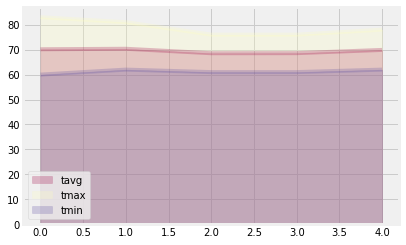

In [99]:
# Plot the daily normals as an area plot with `stacked=False`

# plt.stackplot(df3.date,\
#               df3.tmin,\
#               df3.tavg,\
#               df3.tmax, alpha=.25)

df3.plot(kind='area', stacked=False, alpha=0.25, colormap='Spectral')